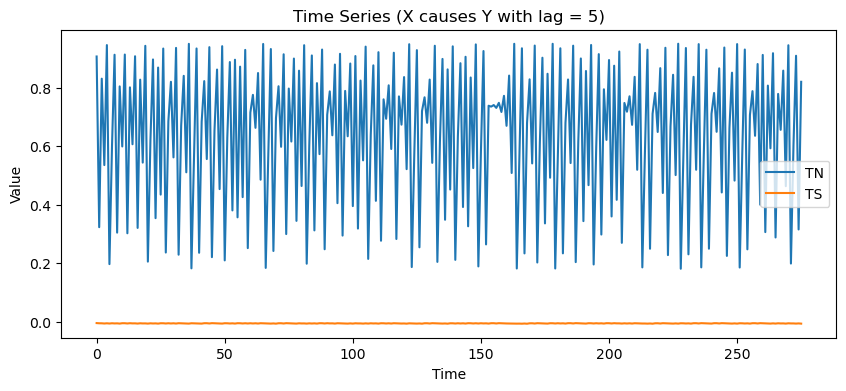

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM
import plotly.graph_objects as go

# PARAMETERS for the new system
r_x = 3.8            
LAG = 5          
t_total = 300    # number of time steps

# Initial conditions
TN0 = 0.4
TS0 = 0.2

# Generate time series
TN = [TN0]
TS = [TS0]

BPS_tau=4
dt=1

for t in range(t_total):
    TN_new = r_x * TN[-1] * (1 - TN[-1])
    # randomly generate TN_new
    # TN_new = np.random.uniform(0, 1) 


    TN.append(TN_new)
    
    if t < LAG:
        TS_new= TS[-1]
    else:
        TS_new= TS[-1] + dt * (1 / BPS_tau) * (-TN[t-LAG+1] - TS[-1])
    TS.append(TS_new)

# CROP THE FIRST 25 VALUES
TN = TN[25:]
TS = TS[25:]
time = list(range(t_total - 25 + 1))    
    


# Plot the time series for X and Y
plt.figure(figsize=(10, 4))
plt.plot(time, TN, label="TN", color='tab:blue')
plt.plot(time, TS, label="TS", color='tab:orange')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Time Series (X causes Y with lag = {LAG})")
plt.legend()
plt.show()

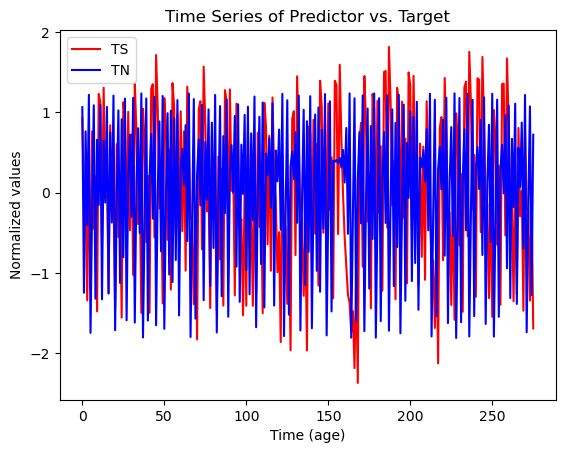

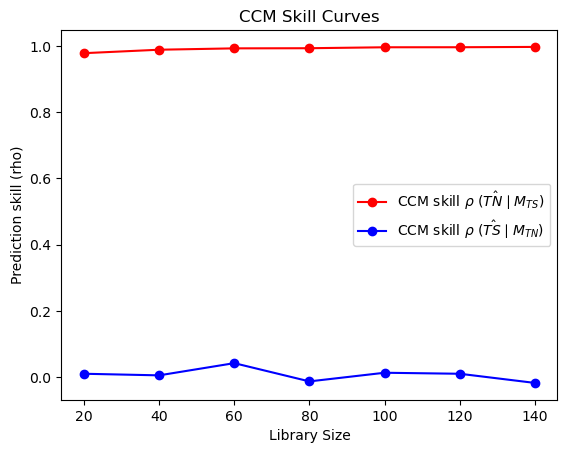

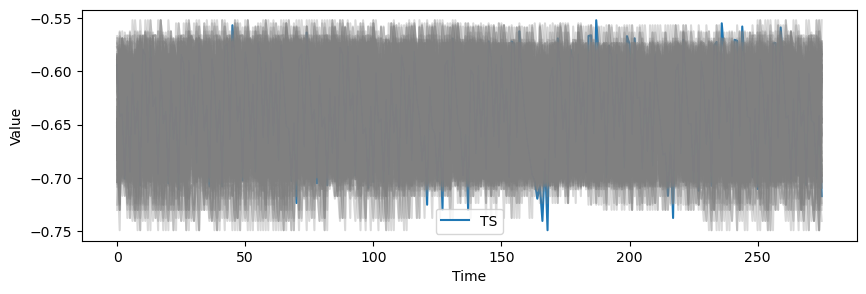

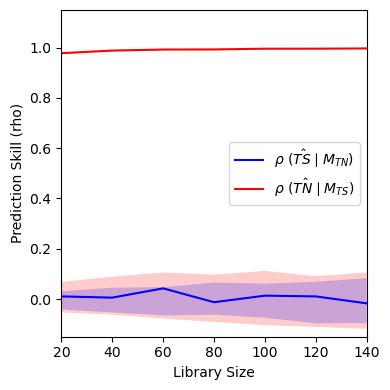

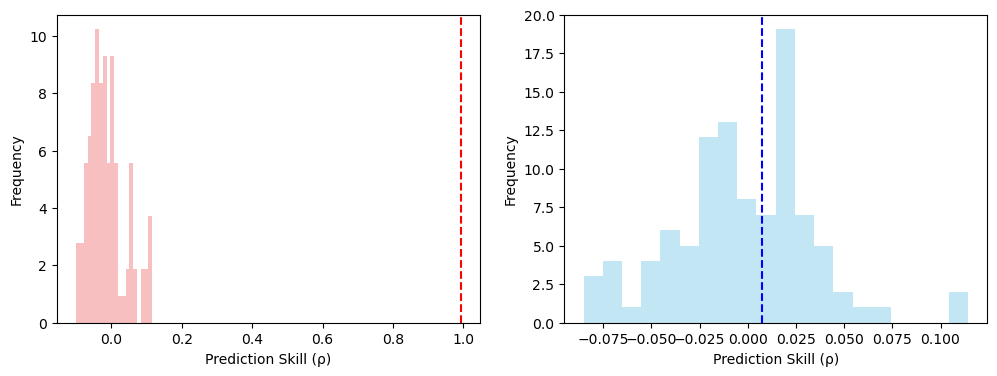

(True, False)


In [2]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt



# Prepare DataFrame
df_TN = pd.DataFrame({
    'age': time,
    'TN': TN,  
})

df_TS = pd.DataFrame({
    'age': time,
    'TS': TS,    
})


from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)


result = cf.ccm_DOXmapForcing(
    df_sd      = df_TS,
    df_pre     = df_TN,
    E          = 2,
    tau        = -1,
    libSizes   = "20 40 60 80 100 120 140",
    Tp=-5,
    sample     = 10,
    showPlot   = True
)

from toolbox import significant_test as st
import importlib
importlib.reload(st)

ccm_out, ran_ccm_list,test_result = st.ccm_significance_test(
    df_sd      = df_TS,
    df_pre     = df_TN,
    E         = 2,
    tau       = -1,
    Tp =-5,
    n_ran     = 100,
    libSizes  = "20 40 60 80 100 120 140",
    sample    = 10,
    showPlot  = True
)


print(test_result)

In [15]:

# Build a dataframe for pyEDM
df = pd.DataFrame({
    "Time": time,
    "TN": TN,
    "TS": TS,
})


Tps = range(-10, 11)  # scanning Tp from -10 to 10
forward_max_rhos = []  # for X -> Y
reverse_max_rhos = []  # for Y -> X

# For each Tp, run CCM
for Tp in Tps:
    ccm_out = CCM(
        dataFrame   = df,
        E           = 2,
        tau         = -1,
        columns     = 'TS',    # use X as the library (predictor)
        target      = 'TN',    # predict Y (target)
        libSizes    = '200',
        sample      = 200,
        random      = True,
        replacement = False,
        Tp          = Tp
    )

    forward_rho = ccm_out['TS:TN'].max()  # X->Y (i.e. predicting Y from X)
    reverse_rho = ccm_out['TN:TS'].max()  # Y->X (predicting X from Y)
    forward_max_rhos.append(forward_rho)
    reverse_max_rhos.append(reverse_rho)

# Plot the CCM skill vs. Tp using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(Tps), 
    y=forward_max_rhos, 
    mode='lines+markers', 
    name="CCM skill ρ (TS xmap TN)",
    line=dict(color='red')  # specify your color here
))

fig.add_trace(go.Scatter(
    x=list(Tps), 
    y=reverse_max_rhos, 
    mode='lines+markers', 
    name="CCM skill ρ (TN xmap TS)",
    line=dict(color='blue')  # specify your color here
))

fig.update_layout(
    title="Max CCM Skill vs. Tp",
    xaxis_title="Tp",
    yaxis_title="Max CCM Skill (rho)",
    width=900,
    height=400
)
fig.update_xaxes(tickmode='array', tickvals=list(Tps))
fig.show()
